In [1]:
from data_generator import *
from init_sdr import *
from main import *
from common import *
from measure import *

from cv_model import *

import json

import json

import ray
import time
import warnings

import torch
import argparse
import ray
from ray import tune
from ray.tune import Trainable
from itertools import product
import itertools

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision import datasets, transforms
from init_sdr import *

import ray
import copy


import time

from sklearn.model_selection import KFold

import argparse

import shutil

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search import ConcurrencyLimiter
from typing import List, Dict

from ray.tune import CLIReporter
import warnings

from ray.tune.search.bayesopt import BayesOptSearch


import math
from test_model import *
from measure import *

import time



from collections import Counter

In [2]:
col_name = ['mean_mse','val_mse', "our_gloss" , 'sir_gloss', 'save_gloss', 'dr_gloss', 'mave_gloss', 'rmave_gloss',
            'our_ploss','sir_ploss', 'save_ploss', 'dr_ploss', 'mave_ploss', 'rmave_ploss',
            'our_closs', 'sir_closs', "save_closs", 'dr_closs','mave_closs', 'rmave_closs']

df = pd.DataFrame(index = range(0,100), columns = col_name)

In [ ]:
best_config = {'h_dim1': 1, 'h_dim2': 20, 'sample_size': 500, 'num_features': 20, 'lambda_0': 0.005, 'lr': 0.025, 
               'epoch': 1000, 'seed': -1, 'model_num': 'model1', 'num_cv': 5, 'or_pen': 'pro', 'dim': 'known'}
start_time = time.time()
for i in range(0, 100):
    
    print('-' * 200)
    print(i+1,"-th Simulation")
    
    
    best_config['data_seed'] = i
    
    #data generator
    d_set = SyntheticDataset(sample_size = best_config['sample_size'], num_features = best_config['num_features'], model_num = best_config['model_num'] , seed = best_config['data_seed'])
    
    d_size = len(d_set)
    d_loader = DataLoader(d_set, batch_size = d_size , shuffle=True)
    
    for train_x, train_y in d_loader:
        X, y = train_x, train_y
    
    # calculate mean model's mse
    y_mean = torch.mean(y)
    mse_mean = torch.mean((y - y_mean) ** 2)
        
    _ , val_mse_list, _, _, model = train_model(best_config, state = 'test')
    
    df.iloc[i,0:2] = mse_mean.item(), val_mse_list[-1]
    
    
    # estimate central mean subspace using our model
    
    dnn_est = model.state_dict()['layer1.weight'].T
    
    # estimate central mean subspace using other SDR models
    
    sir = sdr(X, y, dim = best_config['h_dim1'], mode = 'sir')
    dr = sdr(X, y, dim = best_config['h_dim1'], mode = 'dr')
    save = sdr(X, y, dim = best_config['h_dim1'], mode = 'save')
    mave = sdr(X, y, dim = best_config['h_dim1'], mode = 'mave')
    rmave = sdr(X, y, dim = best_config['h_dim1'], mode = 'rmave')
    
    # true central mean subspace
    
    true_est = CMS(best_config['model_num'], X)
    
    df.iloc[i,2:8] = general_loss(dnn_est, true_est), general_loss(sir, true_est), general_loss(dr, true_est), general_loss(save, true_est), general_loss(mave, true_est), general_loss(rmave, true_est)
    df.iloc[i,8:14] = projection_loss(dnn_est, true_est), projection_loss(sir, true_est), projection_loss(save, true_est), projection_loss(dr, true_est), projection_loss(mave, true_est), projection_loss(rmave, true_est)
    
    
    new_seed = i * 100
    
    new_set = SyntheticDataset(sample_size = best_config['sample_size'], num_features = best_config['num_features'], model_num = best_config['model_num'] , seed = new_seed)
    new_size = len(new_set)
    
    new_loader = DataLoader(new_set, batch_size = new_size , shuffle=True)
    
    for train_x, train_y in new_loader:
        new_X, _ = train_x, train_y

    
    df.iloc[i,14:] = Correlation_loss(dnn_est, true_est, new_X), Correlation_loss(sir, true_est, new_X), Correlation_loss(save, true_est, new_X), Correlation_loss(dr, true_est, new_X), Correlation_loss(mave, true_est, new_X), Correlation_loss(rmave, true_est, new_X)

end_time = time.time()
execution_time = (end_time - start_time) / 60

print("Execution time:", execution_time, "minutes")

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1 -th Simulation
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
2 -th Simulation
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
3 -th Simulation
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
4 -th Simulation
--------------------------------------------------------------------------------------------------------------------------------

In [ ]:
df.to_csv("fixed_d_cv_results/model1_results.csv", index = False)

In [ ]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col])
    
df.head()

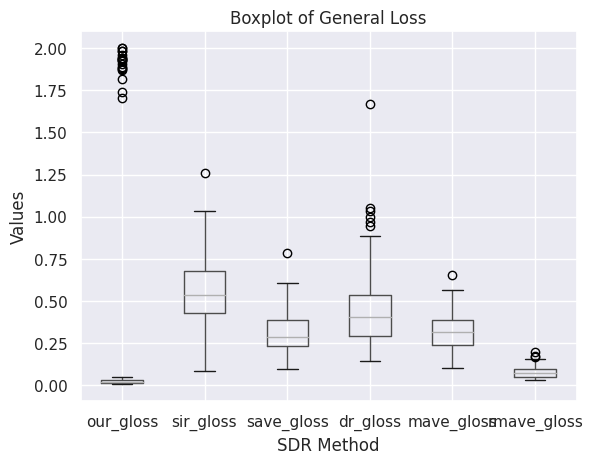

In [6]:
import matplotlib.pyplot as plt


g_loss_coulmns = ['our_gloss', 'sir_gloss', 'save_gloss', 'dr_gloss', 'mave_gloss', 'rmave_gloss']
p_loss_columns = ['our_ploss', 'sir_ploss', 'save_ploss', 'dr_ploss', 'mave_ploss', 'rmave_ploss']
c_loss_columns = ['our_closs', 'sir_closs', 'save_closs', 'dr_closs', 'mave_closs', 'rmave_closs']


df[g_loss_coulmns].boxplot()

plt.title('Boxplot of General Loss')
plt.xlabel('SDR Method')
plt.ylabel('Values')

# 그래프 표시
plt.show()

In [7]:
df[g_loss_coulmns].describe()

,our_gloss,sir_gloss,save_gloss,dr_gloss,mave_gloss,rmave_gloss
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.374289,0.568609,0.313716,0.451940,0.324014,0.077113
std,0.746469,0.205232,0.126228,0.233768,0.110279,0.034767
min,0.004125,0.082328,0.096945,0.142201,0.101904,0.026528
25%,0.010267,0.428793,0.229679,0.293456,0.238625,0.049923
50%,0.015809,0.536547,0.287005,0.402145,0.312712,0.069181
75%,0.026483,0.678616,0.387419,0.532842,0.386003,0.093048
max,1.999956,1.256622,0.782653,1.667610,0.654027,0.196278


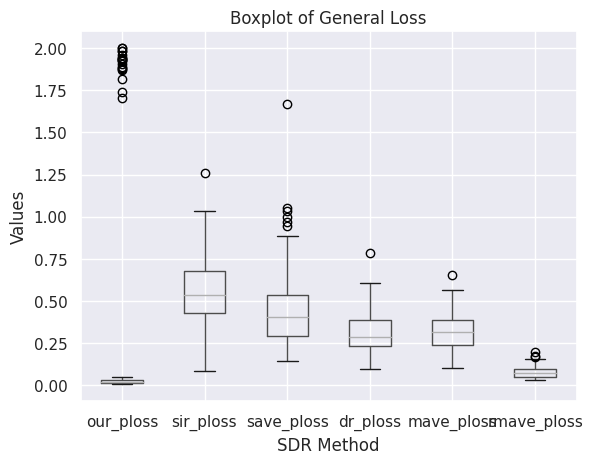

In [8]:
df[p_loss_columns].boxplot()

plt.title('Boxplot of General Loss')
plt.xlabel('SDR Method')
plt.ylabel('Values')

# 그래프 표시
plt.show()

In [10]:
df[p_loss_columns].describe()

,our_ploss,sir_ploss,save_ploss,dr_ploss,mave_ploss,rmave_ploss
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.374289,0.568609,0.451940,0.313716,0.324014,0.077113
std,0.746469,0.205232,0.233768,0.126228,0.110279,0.034767
min,0.004125,0.082328,0.142201,0.096945,0.101904,0.026528
25%,0.010267,0.428793,0.293456,0.229680,0.238625,0.049923
50%,0.015809,0.536547,0.402145,0.287005,0.312712,0.069181
75%,0.026483,0.678616,0.532842,0.387419,0.386003,0.093048
max,1.999957,1.256622,1.667610,0.782653,0.654027,0.196278


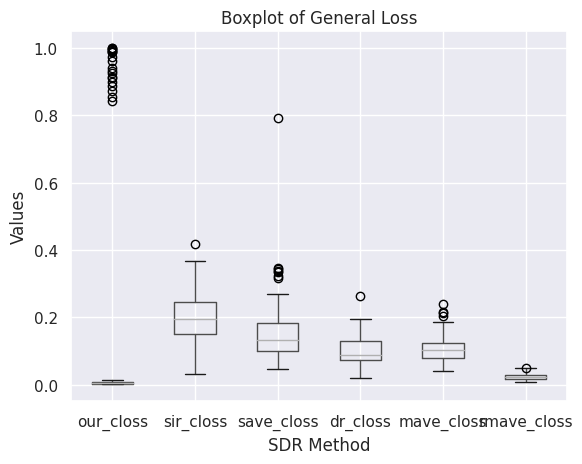

In [9]:
df[c_loss_columns].boxplot()

plt.title('Boxplot of General Loss')
plt.xlabel('SDR Method')
plt.ylabel('Values')

# 그래프 표시
plt.show()

In [11]:
df[c_loss_columns].describe()

,our_closs,sir_closs,save_closs,dr_closs,mave_closs,rmave_closs
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.182673,0.198098,0.155336,0.102301,0.106375,0.023889
std,0.369881,0.071805,0.094693,0.043186,0.039846,0.010089
min,0.001231,0.032269,0.046402,0.020962,0.040803,0.006798
25%,0.003188,0.151184,0.098878,0.073587,0.077928,0.016177
50%,0.004828,0.196541,0.131841,0.088044,0.102388,0.021952
75%,0.008630,0.244247,0.182729,0.129623,0.122592,0.029393
max,0.999692,0.417856,0.792272,0.262853,0.239846,0.049805


In [12]:
df['mean_mse'].describe()

count    100.000000
mean       0.114558
std        0.006302
min        0.102481
25%        0.109901
50%        0.113827
75%        0.118681
max        0.129438
Name: mean_mse, dtype: float64